This is just a quick model I thew together using the weekly player data from the kaggle dataset. I just made sure there was no data leakage between the two sets I used and then I ran some different models and tests on it.

In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load the data
file_path = 'data/weekly_player_data.csv'
df = pd.read_csv(file_path)

# Drop the 'college' feature, as it may not contribute much to predictions
df = df.drop(columns=['college'])

# Dummy encode categorical features: 'opponent' and 'position'
categorical_features = ['opponent', 'position', 'team', 'game_type']
df = pd.get_dummies(df, columns=categorical_features)

# Fill any missing values with zeros
df.fillna(0, inplace=True)

# Check the DataFrame
print("Data after dropping 'college' and dummy encoding:")
print(df.head())

Data after dropping 'college' and dummy encoding:
    player_id player_name  season  week  pass_attempts  complete_pass  \
0  00-0035676  A.J. Brown    2019     1            0.0            0.0   
1  00-0035676  A.J. Brown    2019     2            0.0            0.0   
2  00-0035676  A.J. Brown    2019     3            0.0            0.0   
3  00-0035676  A.J. Brown    2019     4            0.0            0.0   
4  00-0035676  A.J. Brown    2019     5            0.0            0.0   

   incomplete_pass  passing_yards  passing_air_yards  pass_td  ...  team_NYG  \
0              0.0            0.0                0.0      0.0  ...     False   
1              0.0            0.0                0.0      0.0  ...     False   
2              0.0            0.0                0.0      0.0  ...     False   
3              0.0            0.0                0.0      0.0  ...     False   
4              0.0            0.0                0.0      0.0  ...     False   

   team_NYJ  team_PHI  team_PI

In [3]:
from sklearn.model_selection import GroupShuffleSplit

# GroupShuffleSplit to split data by player_id
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
player_ids = df['player_id']

# Split indices using GroupShuffleSplit
train_idx, test_idx = next(splitter.split(df, groups=player_ids))

# Create train and test DataFrames based on split indices
df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

# Separate features and target (keep all features except target)
X_train = df_train.drop(columns=['fantasy_points_ppr', 'player_id', 'player_name'])
y_train = df_train['fantasy_points_ppr']
X_test = df_test.drop(columns=['fantasy_points_ppr', 'player_id', 'player_name'])
y_test = df_test['fantasy_points_ppr']

In [4]:
def check_for_data_leakage(train_df, test_df):
    # Ensure player_id is present in both DataFrames
    if 'player_id' not in train_df.columns or 'player_id' not in test_df.columns:
        raise ValueError("Both DataFrames must contain a 'player_id' column to check for data leakage.")
    
    # Find overlapping player IDs
    common_players = set(train_df['player_id']).intersection(set(test_df['player_id']))
    
    if len(common_players) > 0:
        print(f"Data Leakage Found! Number of common player IDs: {len(common_players)}")
        print(f"Common player IDs: {common_players}")
    else:
        print("No data leakage detected. Training and test sets are distinct.")

# Run the function to check for data leakage
check_for_data_leakage(df_train, df_test)


No data leakage detected. Training and test sets are distinct.


In [5]:
# Replace infinity values with the maximum finite value in the column
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any remaining NaN values with zeros or the mean of the column
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Verifying if X_train and X_test contain any more infinity or NaN values:")
print(np.isinf(X_train).sum(), np.isnan(X_train).sum())
print(np.isinf(X_test).sum(), np.isnan(X_test).sum())


Verifying if X_train and X_test contain any more infinity or NaN values:
season             0
week               0
pass_attempts      0
complete_pass      0
incomplete_pass    0
                  ..
team_SF            0
team_TB            0
team_TEN           0
team_WAS           0
game_type_REG      0
Length: 127, dtype: int64 season             0
week               0
pass_attempts      0
complete_pass      0
incomplete_pass    0
                  ..
team_SF            0
team_TB            0
team_TEN           0
team_WAS           0
game_type_REG      0
Length: 127, dtype: int64
season             0
week               0
pass_attempts      0
complete_pass      0
incomplete_pass    0
                  ..
team_SF            0
team_TB            0
team_TEN           0
team_WAS           0
game_type_REG      0
Length: 127, dtype: int64 season             0
week               0
pass_attempts      0
complete_pass      0
incomplete_pass    0
                  ..
team_SF            0
team_TB  

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression R^2 Score: {r2}")


Linear Regression MSE: 3.310277922196981e-28
Linear Regression R^2 Score: 1.0


In [8]:
from sklearn.linear_model import Ridge

# Use Ridge Regression to add regularization
ridge_model = Ridge(alpha=1.0)  # Adjust alpha to control the strength of regularization
ridge_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_ridge_pred = ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_ridge_pred)
r2_ridge = r2_score(y_test, y_ridge_pred)

print(f"Ridge Regression MSE: {mse_ridge}")
print(f"Ridge Regression R^2 Score: {r2_ridge}")


Ridge Regression MSE: 2.0236695571242326e-07
Ridge Regression R^2 Score: 0.9999999972917827


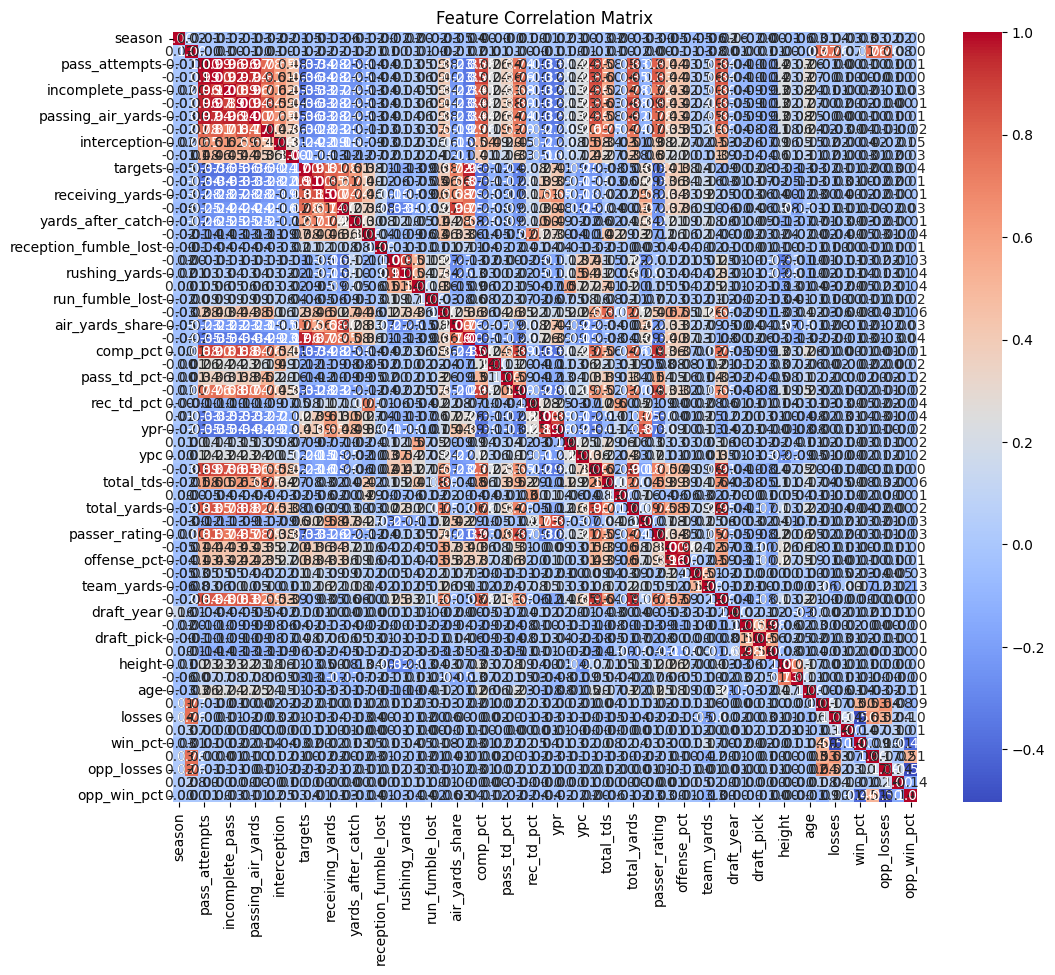

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Plot correlation matrix using only numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


In [10]:
from sklearn.decomposition import PCA
import numpy as np

# Fit and transform the data using PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print explained variance ratio to understand the components
print("Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_))
print("Number of Components:", pca.n_components_)


Explained Variance Ratio: 0.9532336504329031
Number of Components: 86


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on PCA-transformed training data
model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_pca = model.predict(X_test_pca)

# Evaluate the model
mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"Mean Squared Error (MSE) after PCA: {mse_pca}")
print(f"R² Score after PCA: {r2_pca}")


Mean Squared Error (MSE) after PCA: 3.546844371668379
R² Score after PCA: 0.9525336264672927


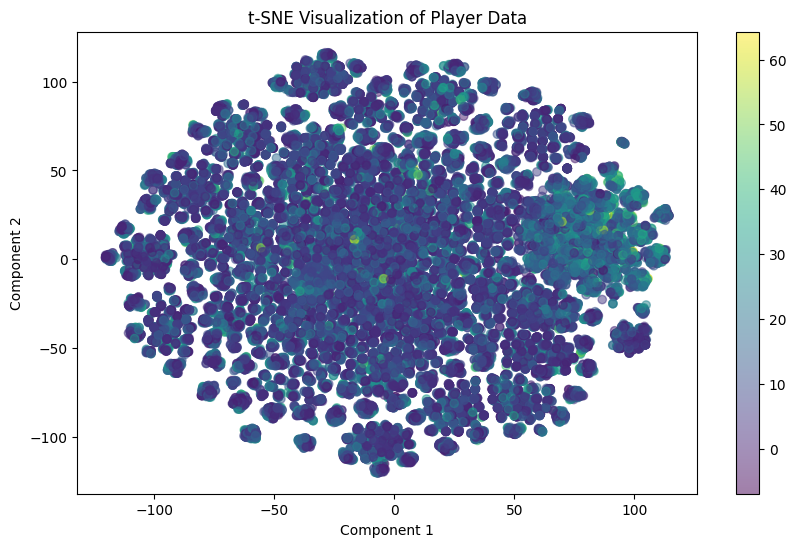

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality to 2 components for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Plotting the t-SNE reduced components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization of Player Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the K-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)  # Choose k based on cross-validation tuning

# Train the model on PCA-transformed data
knn_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_pca)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regression MSE: {mse_knn}")
print(f"KNN Regression R² Score: {r2_knn}")


KNN Regression MSE: 26.169643437494052
KNN Regression R² Score: 0.6497793699255108
